<a href="https://colab.research.google.com/github/mahadi0007/4.1-soft-computing/blob/Assignment-3-(NLP)/170104102%20(assignment%203).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [2]:
import numpy as np
import pandas as pd
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import random
from seaborn import countplot
from matplotlib import pyplot
import seaborn as sns

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameter

In [4]:
# Hyper-parameters
input_size = 50
hidden_size = 128
num_layers = 3
num_classes = 2
batch_size = 100
num_epochs = 30
learning_rate = 0.001

# Confusion Matrix

In [5]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

# Read Dataframe

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/soft computing assignment 3/Dataset 1.csv', encoding = "ISO-8859-1")
random.seed(42)
df = df.sample(frac = 1)

df.head(15)

,message,label
9673,Depression works very much like this.*minor in...,1
31,"it's cold, man am i loving this weather",0
1610,"@takeitgreen oooh, that looks really good inde...",0
1974,http://twitpic.com/5ohy5 - @bencoder Hello bc ...,0
7407,@hitesha jive on a monday nite..howz that for ...,0
9633,"@Nice_White_Lady Not good, not in crisis mode ...",1
497,"@brother_rat yep, if there's one thing they ar...",0
6418,@KiairaEST1989 lol craziness! Hopefully I make...,0
9316,Could 'one puff' of cannabis ease depression? ...,1
8870,"Every single person in the world"", every cultu...",1


# Data Visualisation

0 =  8000 
1 =  2314


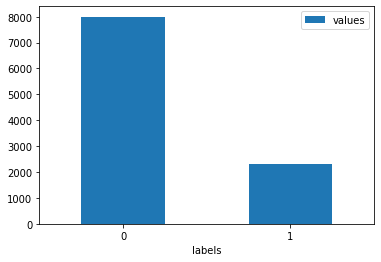

In [7]:
label_count = df.label.value_counts()
label_0 = label_count[0]
label_1 = label_count[1]
print('0 = ',label_0, '\n1 = ', label_1)


grph = pd.DataFrame({'labels':['0', '1'], 'values':label_count})
ax = grph.plot.bar(x='labels', y='values', rot=0)

# Data Preprocessing

## Converting Lowercase

In [8]:
#CONVERTING TO LOWERCASE
df['message'] = df['message'].str.lower()
df

,message,label
9673,depression works very much like this.*minor in...,1
31,"it's cold, man am i loving this weather",0
1610,"@takeitgreen oooh, that looks really good inde...",0
1974,http://twitpic.com/5ohy5 - @bencoder hello bc ...,0
7407,@hitesha jive on a monday nite..howz that for ...,0
...,...,...
8715,lmao someone come slap the depression out of m...,1
637,@davidcoallier 1 at the cakery,0
3579,1st wedding anniversary today here's to many...,0
5442,i'm sure the ting tings could do the same thing.,0


## Stopword Remove

In [9]:
#REMOVING THE STOP WORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,message,label
9673,depression works much like this.*minor inconve...,1
31,"cold, man loving weather",0
1610,"@takeitgreen oooh, looks really good indeed! i...",0
1974,http://twitpic.com/5ohy5 - @bencoder hello bc ...,0
7407,@hitesha jive monday nite..howz idea,0
...,...,...
8715,lmao someone come slap depression pls n thx,1
637,@davidcoallier 1 cakery,0
3579,1st wedding anniversary today here's many blis...,0
5442,i'm sure ting tings could thing.,0


## Mention Remove

In [10]:
def remove_Mention(s):
    s = re.sub(r'@[\S]+', ' ', s)
    return s
df['message'] = df['message'].apply(lambda text: remove_Mention(text))
df

,message,label
9673,depression works much like this.*minor inconve...,1
31,"cold, man loving weather",0
1610,"oooh, looks really good indeed! i'm sorry sp...",0
1974,http://twitpic.com/5ohy5 - hello bc meta-gam...,0
7407,jive monday nite..howz idea,0
...,...,...
8715,lmao someone come slap depression pls n thx,1
637,1 cakery,0
3579,1st wedding anniversary today here's many blis...,0
5442,i'm sure ting tings could thing.,0


## URL Remove

In [11]:
#REMOVING URL
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
df['message'] = df['message'].apply(lambda text: remove_URL(text))
df

,message,label
9673,depression works much like this.*minor inconve...,1
31,"cold, man loving weather",0
1610,"oooh, looks really good indeed! i'm sorry sp...",0
1974,- hello bc meta-game. watch space ;d,0
7407,jive monday nite..howz idea,0
...,...,...
8715,lmao someone come slap depression pls n thx,1
637,1 cakery,0
3579,1st wedding anniversary today here's many blis...,0
5442,i'm sure ting tings could thing.,0


## Number Remove

In [12]:
def remove_Number(s):
    s = ''.join(c for c in s if not c.isdigit())
    return s
df['message'] = df['message'].apply(lambda text: remove_Number(text))
df

,message,label
9673,depression works much like this.*minor inconve...,1
31,"cold, man loving weather",0
1610,"oooh, looks really good indeed! i'm sorry sp...",0
1974,- hello bc meta-game. watch space ;d,0
7407,jive monday nite..howz idea,0
...,...,...
8715,lmao someone come slap depression pls n thx,1
637,cakery,0
3579,st wedding anniversary today here's many bliss...,0
5442,i'm sure ting tings could thing.,0


## Hashtag Remove

In [13]:
def rmove_Hastag(s):
    s = re.sub("#[A-Za-z0-9_]+","", s)
    return s
df['message'] = df['message'].apply(lambda text: rmove_Hastag(text))
df

,message,label
9673,depression works much like this.*minor inconve...,1
31,"cold, man loving weather",0
1610,"oooh, looks really good indeed! i'm sorry sp...",0
1974,- hello bc meta-game. watch space ;d,0
7407,jive monday nite..howz idea,0
...,...,...
8715,lmao someone come slap depression pls n thx,1
637,cakery,0
3579,st wedding anniversary today here's many bliss...,0
5442,i'm sure ting tings could thing.,0


## Punctuation Remove

In [14]:
#REMOVING PUNCTUATIONS
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '') 
    return text
df['message'] = df['message'].apply(remove_punctuations)
df

,message,label
9673,depression works much like thisminor inconveni...,1
31,cold man loving weather,0
1610,oooh looks really good indeed im sorry spamm...,0
1974,hello bc metagame watch space d,0
7407,jive monday nitehowz idea,0
...,...,...
8715,lmao someone come slap depression pls n thx,1
637,cakery,0
3579,st wedding anniversary today heres many blissf...,0
5442,im sure ting tings could thing,0


## Stemming

In [15]:
#STEMMING
from nltk.stem.porter import PorterStemmer 

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['message'] = df['message'].apply(lambda text: stem_words(text))
df

,message,label
9673,depress work much like thisminor inconvenience...,1
31,cold man love weather,0
1610,oooh look realli good inde im sorri spam twitt...,0
1974,hello bc metagam watch space d,0
7407,jive monday nitehowz idea,0
...,...,...
8715,lmao someon come slap depress pl n thx,1
637,cakeri,0
3579,st wed anniversari today here mani bliss happi...,0
5442,im sure ting ting could thing,0


## Empty Row Remove

In [16]:
df['message'].replace('', np.nan, inplace=True)

In [17]:
df

,message,label
9673,depress work much like thisminor inconvenience...,1
31,cold man love weather,0
1610,oooh look realli good inde im sorri spam twitt...,0
1974,hello bc metagam watch space d,0
7407,jive monday nitehowz idea,0
...,...,...
8715,lmao someon come slap depress pl n thx,1
637,cakeri,0
3579,st wed anniversari today here mani bliss happi...,0
5442,im sure ting ting could thing,0


In [18]:
df.dropna(subset=['message'], inplace=True)

In [19]:
df

,message,label
9673,depress work much like thisminor inconvenience...,1
31,cold man love weather,0
1610,oooh look realli good inde im sorri spam twitt...,0
1974,hello bc metagam watch space d,0
7407,jive monday nitehowz idea,0
...,...,...
8715,lmao someon come slap depress pl n thx,1
637,cakeri,0
3579,st wed anniversari today here mani bliss happi...,0
5442,im sure ting ting could thing,0


## Tokenize Message

In [20]:
tknzr = TweetTokenizer(strip_handles=True)
def tweet_tokenizer(text):
    return tknzr.tokenize(text)
df['message'] = df['message'].apply(tweet_tokenizer)

In [21]:
df

,message,label
9673,"[depress, work, much, like, thisminor, inconve...",1
31,"[cold, man, love, weather]",0
1610,"[oooh, look, realli, good, inde, im, sorri, sp...",0
1974,"[hello, bc, metagam, watch, space, d]",0
7407,"[jive, monday, nitehowz, idea]",0
...,...,...
8715,"[lmao, someon, come, slap, depress, pl, n, thx]",1
637,[cakeri],0
3579,"[st, wed, anniversari, today, here, mani, blis...",0
5442,"[im, sure, ting, ting, could, thing]",0


# Train Test Split

In [22]:
train, test = train_test_split(df,test_size=0.2, random_state=42)
train, valid = train_test_split(train,test_size=0.2, random_state=42)

# Glove Load

In [23]:
# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20000)

# Making Data Loader

In [24]:
def get_tweet_vectors(glove_vector, dataframe):
  vectorList = []
  for index, row in dataframe.iterrows():
    tweet = row['message']
    vector_sum = sum(glove_vector[w] for w in tweet)
    label = row['label']
    vectorList.append((vector_sum, label))
  return vectorList

In [25]:
train = get_tweet_vectors(glove, train)
test = get_tweet_vectors(glove, test)
valid = get_tweet_vectors(glove, valid)

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)

# Three Recurrent Layer RNN

### Step #1 : Design model using class

In [26]:
#credit : https://github.com/yunjey/pytorch-tutorial/

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [27]:
'''
INSTANTIATE MODEL CLASS
'''
model = RNN(input_size, hidden_size, num_layers, num_classes)

# To enable GPU
model.to(device)

RNN(
  (rnn): RNN(50, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

### Step #2 : Construct loss and optimizer

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step #3 : Training: forward, loss, backward, step

In [29]:
iteration_loss = []
for epoch in range(num_epochs):
  for i, (messages, labels) in enumerate(train_loader):
    messages = messages.unsqueeze(-2).to(device)
    labels = labels.to(device)
    model.zero_grad()
    output = model(messages)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
  if epoch % 5 == 4:
    # For Testing Data
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through dataset
    for i, (messages, labels) in enumerate(test_loader):
      messages = messages.unsqueeze(-2).to(device)

      # Forward pass only to get logits/output
      output = model(messages)

      # Get predictions from the maximum value
      _, predicted = torch.max(output, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    if epoch>25 and  loss.item()> iteration_loss[-1]:
      break
    iteration_loss.append(loss.item())
    test_accuracy = 100 * correct.item() / total
    # For Validating Data
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through dataset
    for i, (messages, labels) in enumerate(valid_loader):
      messages = messages.unsqueeze(-2).to(device)

      # Forward pass only to get logits/output
      output = model(messages)

      # Get predictions from the maximum value
      _, predicted = torch.max(output, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    validation_accuracy = 100 * correct.item() / total
    # Print Loss
    print('Epoch: {}. Loss: {}. Testing Accuracy: {}. Validation Accuracy: {}'.format(epoch+1, iteration_loss[-1], test_accuracy, validation_accuracy))

Epoch: 5. Loss: 0.3117421865463257. Testing Accuracy: 85.60311284046692. Validation Accuracy: 85.47112462006079
Epoch: 10. Loss: 0.2531225383281708. Testing Accuracy: 85.50583657587549. Validation Accuracy: 85.34954407294833
Epoch: 15. Loss: 0.32687467336654663. Testing Accuracy: 85.3112840466926. Validation Accuracy: 85.16717325227964
Epoch: 20. Loss: 0.19229824841022491. Testing Accuracy: 85.06809338521401. Validation Accuracy: 85.34954407294833
Epoch: 25. Loss: 0.2629373073577881. Testing Accuracy: 85.3112840466926. Validation Accuracy: 85.16717325227964
Epoch: 30. Loss: 0.1375165730714798. Testing Accuracy: 83.36575875486382. Validation Accuracy: 82.67477203647417


### Iteration Vs Loss

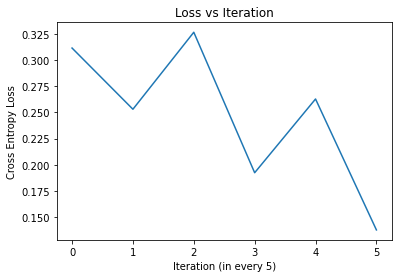

In [30]:
plt.title("Loss vs Iteration")
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 5)')
plt.show()

In [31]:
def get_all_prediction(loader):
  predictions_list = torch.tensor([], dtype=torch.int32)
  labels_list = torch.tensor([], dtype=torch.int32)
  for i, (messages, labels) in enumerate(loader):
    messages = messages.unsqueeze(-2).to(device)

    # Forward pass only to get logits/output
    outputs = model(messages)

    # Get predictions from the maximum value
    _, predictions = torch.max(outputs, 1)
    predictions_list = torch.cat((predictions_list, predictions.cpu()), dim = 0)
    labels_list = torch.cat((labels_list.cpu(), labels.cpu()), dim = 0).to(device)
  return predictions_list, labels_list.cpu()

Accuracy: 83.36575875486382
Precision: 83.36575875486382
Recall: 83.36575875486382
F1 score: 83.3657587548638


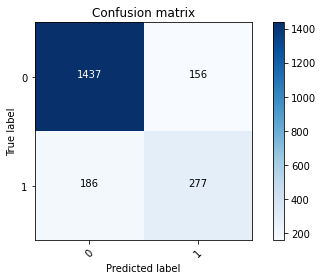

In [32]:
y_pred, y_true = get_all_prediction(test_loader)
print('Accuracy: ' +str(accuracy_score(y_true, y_pred) * 100))
print('Precision: ' +str(precision_score(y_true, y_pred, average='micro') * 100))
print('Recall: ' +str(recall_score(y_true, y_pred, average='micro') * 100))
print('F1 score: ' +str(f1_score(y_true, y_pred, average='micro')  * 100))
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Prediction

In [33]:
root_path = "/content/drive/MyDrive/Colab Notebooks/soft computing assignment 3/"
torch.save(model.state_dict(), root_path + 'RNN.pkl')

In [34]:
model.load_state_dict(torch.load(root_path + 'RNN.pkl'))

<All keys matched successfully>

In [35]:
def predict_sentiment(messages):
  messages = sum(glove[w] for w in messages)
  messages = messages.reshape(1, 1, 50).to(device)
  output = model(messages)
  _, predicted = torch.max(output, 1)
  if predicted > 0.5:
    print('Positive sentiment')
  else:
    print('Negative sentiment')

In [38]:
test_text = input()
predict_sentiment(test_text)

I am happy
Positive sentiment
